# Numerical potential: bound and continuum states

The present notebook introduces how to find the eigenvalues of a numerical Hamiltonian using `SiegPy`. We will focus on the 1D Square-Well Potential (1DSWP) case, for comparisons with analytical results to be possible.

## Initialization

The initialization only consists in importing all the necessary modules and classes and defining the potential to be used throughout the notebook.

### Import classes and modules

You should be familiar with every import from `SiegPy` except the last three. 

We'll see that finding numerical eigenstates of a potential requires a `Hamiltonian` instance, the latter taking a coordinate mapping as argument to be initialized, hence the `UniformCoordMap` (we will soon explain what do we mean by that). `BasisSet` is the most general class defining a basis set in `SiegPy`. The `SWPBasisSet` class extensively used throughout the previous notebooks actually inherits from the `BasisSet` class.

In [1]:
from siegpy import (SWPotential, SWPBasisSet, BasisSet,
                    Hamiltonian, UniformCoordMap)
# We also import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

### Define a potential

We first read a basis set made of analytical Siegert states from a file, in order to easily compare our future numerical results with the analytical ones. We can then reuse the same potential, except that it has to be discretized over a grid.

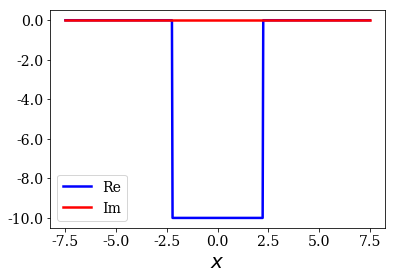

In [2]:
# Read the analytical basis set made of Siegert states
siegerts = SWPBasisSet.from_file("siegerts.dat")

# Find its potential, and discretize it over a grid
pot = siegerts.potential
l = pot.width
xmax = 7.5
xgrid = np.linspace(-xmax, xmax, 501)
pot.grid = xgrid
pot.plot()

## Finding numerical eigenstates

Finding numerical solutions of a Hamiltonian is done in two times:

* first, a `Hamiltonian` is defined in matrix form, 

* and then its eigenvalues and eigenvectors are found in order to create a `BasisSet` instance.

### Define the Hamitonian

The Hamiltonian is made of the sum of the kinetic and potential terms. In order to write it in matrix form, the Laplacian operator also has to be defined in matrix form. 

This requires the use of a set of filters (i.e., a set of coefficients) (see [here](https://en.wikipedia.org/wiki/Finite_difference_coefficient) for some finite difference filters up to order 8). For example, the finite difference filter of order 1 of the Laplacian reads `[1, -2, 1]`, meaning that the derivative of a function $f$ at a given grid point $x_n$ reads $f''(x_n) \approx \frac{f(x_{x-1}) - 2 f(x_n) + f(x_{n+1})}{h^2}$. The defaults filters used consist of more complex Daubechies wavelets filters (named `Sym8_filters`). 

The main goal of the SiegPy module is to study the Siegert states of a given potential, and this requires the use of a Complex Scaling (CS) method, consisting of a given coordinate mapping $F$ such that the usual position $x$ is transformed into $F(x)$. A Hamiltonian therefore requires a coordinate mapping as argument. However, we are only interested in finding the usual solution of the Hamiltonian, *i.e.* we want $F(x) = x$. This is easily achieved by taking a so-called uniform coordinate mapping $F(x) = x e^{i \theta}$ with $\theta = 0$. Such a coordinate mapping is defined in the first line of the following cell.


**Notes:**

* The Laplacian filter is not the only one used, the gradient filter is also often required to define the virial (see below) and Hamiltonian operators, hence the plural for filters used above. The wavelet filters also require a so-called magic filter.

* Even though Daubechies wavelets filters are used as default, finite difference filters of order 2 and 8 are also provided in `SiegPy` (they are named `FD2_filters` and `FD8_filters` respectively). To use them, you only need to import them from `SiegPy` and specify the `filters` optional argument of the `Hamiltonian` class.

* More filters can easily be created thanks to the `Filters` and `WaveletFilters` class (imported with the command `from siegpy.filters import Filters, WaveletFilters`)

In [3]:
# Initialize the coordinate mapping $F: x \mapsto x$ 
cm = UniformCoordMap(0)

# Initialize the Hamiltonian
ham = Hamiltonian(pot, cm)
# To use another set of filters, uncomment the following lines:
# from siegpy import FD2_filters
# ham = Hamiltonian(pot, cm, filters=FD2_filters)

### Solve the Hamiltonian

You then only need to apply the `solve` method to the `Hamiltonian` instance `ham`, and this returns a `BasisSet` instance. It doesn't get any simpler than this!

In [4]:
basis = ham.solve()
type(basis)

siegpy.basisset.BasisSet

The basis set is made of `Eigenstate` instances. For example, the first state correspond to the bound state with the lowest energy:

<class 'siegpy.eigenstates.Eigenstate'>
(-9.796086879584973+0j)


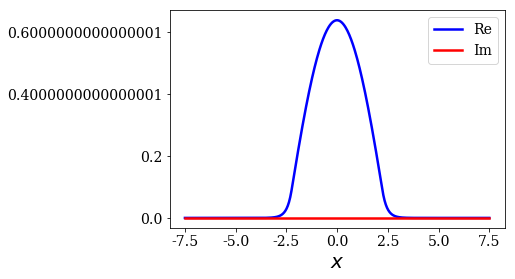

In [5]:
first_state = basis[0]
print(type(first_state))
print(first_state.energy)
first_state.plot()

The basis set is made of the same number of states as the dimension of the Hamiltonian matrix, that is the number of grid points.

In [6]:
len(basis) == len(ham.matrix) == len(xgrid)

True

The states are divided in two categories: the bound and continuum states:

In [7]:
len(basis.bounds), len(basis.continuum)

(7, 494)

The first category is made of the states with negative energy, while the other is made of the states of positive energy.

## Create plots of the basis set

We can plot the the energies of the basis set. The energy range is limited here to show that the spectrum of continuum states cannot be as regular as it was in the analytical case:

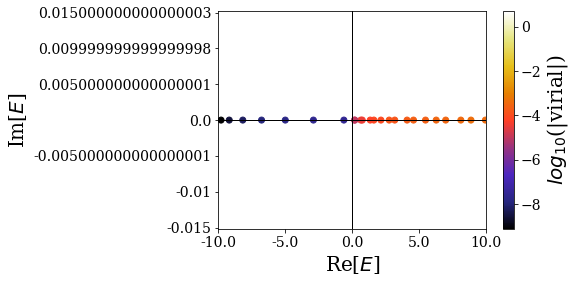

In [8]:
basis.plot_energies(xlim=(-10, 10))

A virial value is attributed to each of the states in the basis set. This will allow us to discriminate Siegert states from the other types of states (the lower the virial, the more likely the state can be considered as a Siegert state). You can already see that bound states have virial values orders of magnitude below those of the continuum states. 

**Notes:**

* The eigenstates in the basis set are sorted by increasing virial value.

* See [here](http://arxiv.org/abs/1504.00536) for a reference on how the virial operator is defined.

A broader view is given here, where the wavenumbers of all the states are plotted:

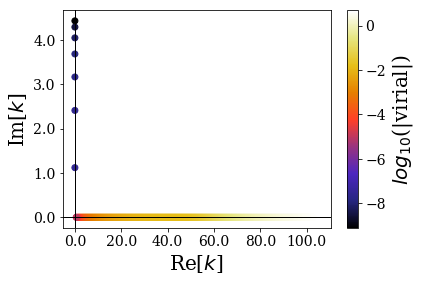

In [9]:
basis.plot_wavenumbers()

The continuum states wavenumbers extend to large values along the real axis. It is interesting to note that the virial values of all the continuum states is order of magnitudes below that of bound states: the expectation values of the virial operator allow to separate Siegert states from other types of states. This virial operator actually measures if the position-momentum commutator, when applied to a given eigenstate $\varphi$ is such that $\left\langle \varphi | [\hat{X}, \hat{P}] | \varphi \right\rangle = i \left\langle \varphi | \varphi \right\rangle$. This equality is verified numerically for bound states, but not for continuum states.

The wavefunctions can also be plotted. You can set the number of states to plot with the `nstates` optional argument. You can also plot the potential by passing it as argument:

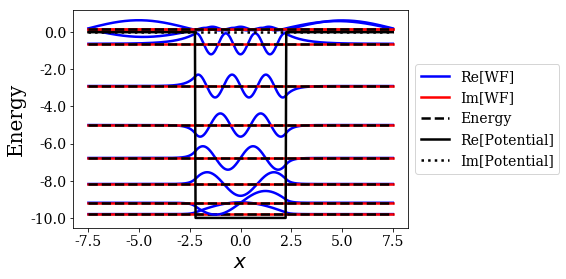

In [10]:
basis.plot_wavefunctions(nstates=9)

Here, the 9 first states correspond to the seven bound states of the potental and the first two continuum states, that are almost degenerate.

## Comparison with the analytical bound states

The numerical and analytical bound states can be easily compared:

In [11]:
# Create a basis set made of the numerical bound states only
numerical_bounds = basis.bounds
# Create a basis set made of the analytical bound states only
exact_bounds = siegerts.bounds
exact_bounds.grid = xgrid  # Use the same grid

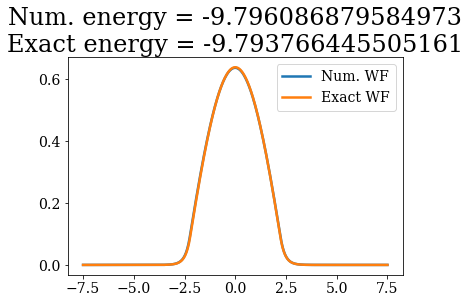

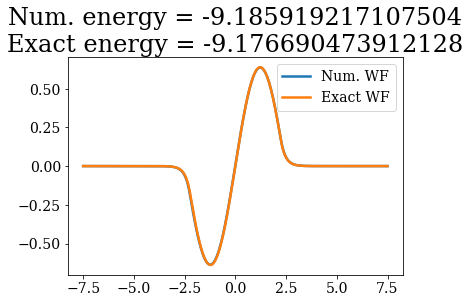

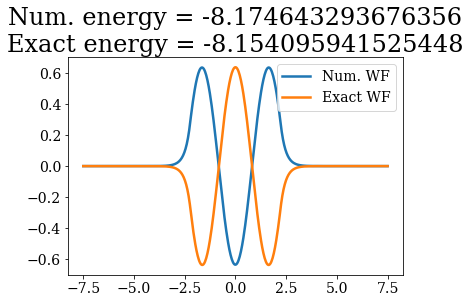

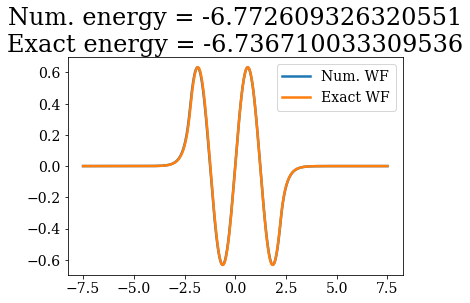

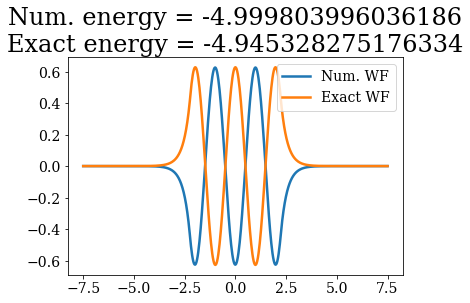

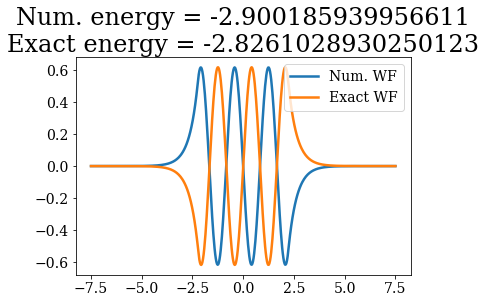

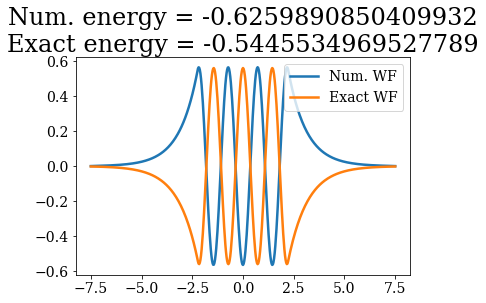

In [12]:
# Loop over both basis set, to plot the bound states wavefunctions
# and compare their energies
for i in range(len(exact_bounds)):
    title = "Num. energy = {0.real}\nExact energy = {1.real}"\
            .format(numerical_bounds[i].energy,
                    exact_bounds[i].energy)
    plt.plot(numerical_bounds[i].grid,
             np.real(numerical_bounds[i].values), label="Num. WF")
    plt.plot(exact_bounds[i].grid,
             np.real(exact_bounds[i].values), label="Exact WF")
    plt.legend()
    plt.title(title)
    plt.show()

Except for a phase factor for some bound states, the numerical bound states wavefunctions coincide to the analytical ones. The energies are also in a correct agreement. Note that the agreement is worse for the highest energy bound states. This is due to the fact the grid is finite: extending it to larger values (*i.e.*, increasing `xmax`) and increasing the density of grid points would lead to an even better correspondence (and lower virials).

## Numerical continuum states

Let us plot the lowest virial continuum states:

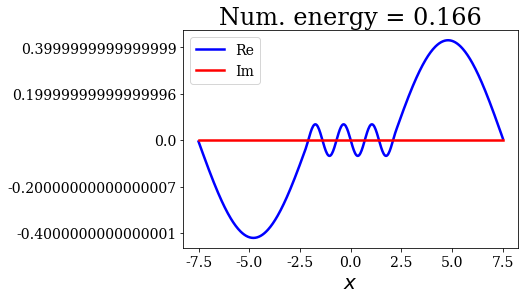

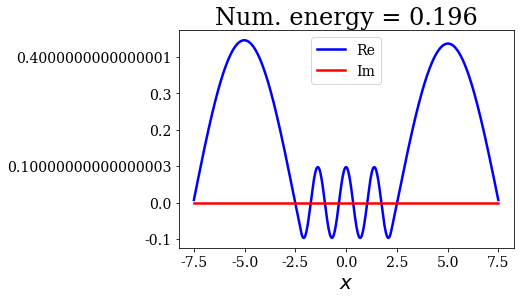

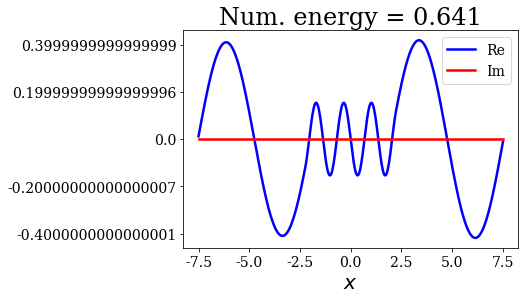

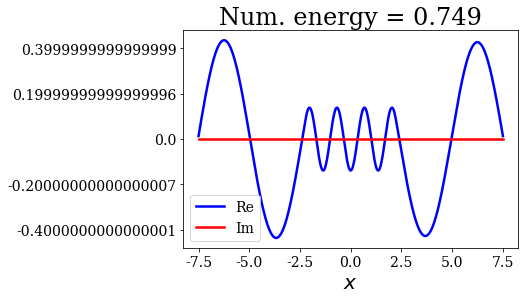

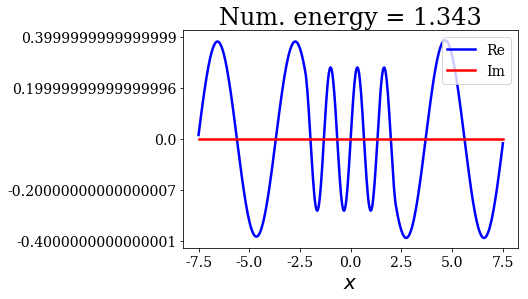

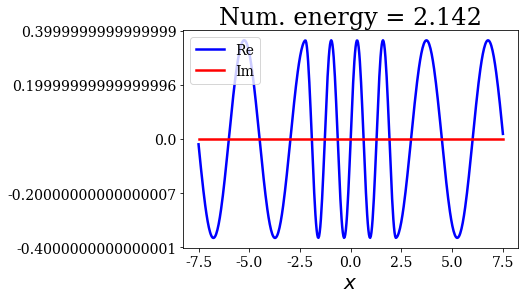

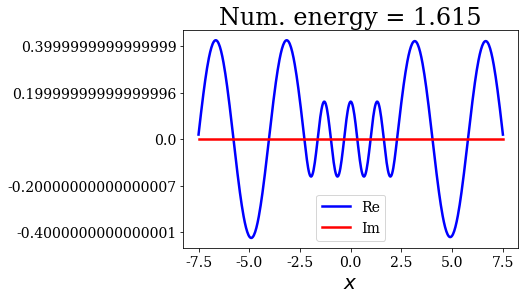

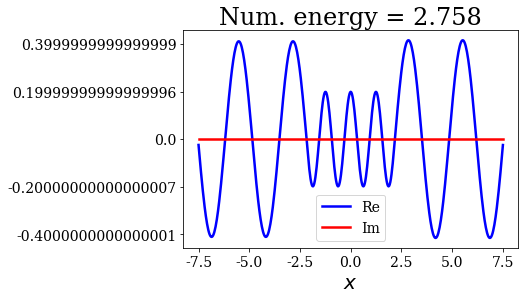

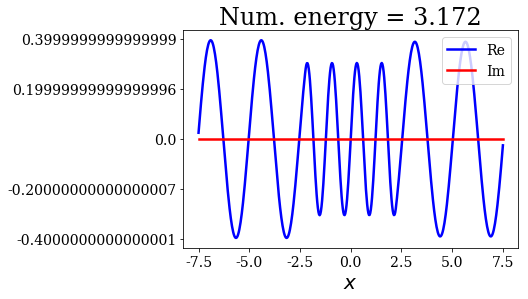

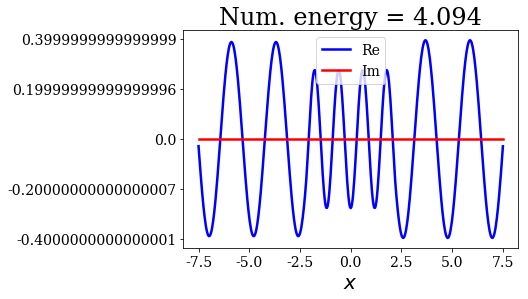

In [13]:
numerical_continuum = basis.continuum
for state in numerical_continuum[:10]:
    title = "Num. energy = {0.real:.3f}".format(state.energy)
    state.plot(title=title)

In general, the lowest the virial value, the lowest the continuum state energy, but there may be some exceptions. Just like the analytical continuum states, they exhibit a constant amplitude of the nodes in each region, the amplitudes being the same in region $I$ and $III$.

**Notes:** 

* The oscillations of the wavefunctions in region $I$ and $III$ (outside of the potential) are associated to particle in a box: there is an increasing number of sinusoid oscillations in these regions (for a given number of nodes in region $II$). For example, the first and third continuum state are very similar in region $II$, but not in region $I$ and $III$, where the latter wavefunction exhibit one more node in each of these regions. This comes from the fact that the grid is finite: it as if the finite square well potential was embedded in an larger, infinite square-well potential.

* Numerical continuum states go by pair, but they are not degenerate. See, for instance, the first and second states.

## Conclusion

This notebook focused on presenting how to define a numerical Hamiltonian and how to solve it to find bound and continuum states. This requires the definition of a coordinate mapping $F$, that is simply $F: x \mapsto x$ here. More refined coordinate mappings will be presented in other notebooks, allowing to find numerical resonant states of a numerical potential.

We saw that the methods used to plot the energies, wavenumbers and wavefunctions in the analytical case can still be used. 

Finally, the bound states found are comparable to the the analytical ones.